In [33]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

In [34]:
tf.__version__

'2.7.0'

In [35]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
def load_data(data_dir, image_height, image_width, batch_size):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

    val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

    return train_ds, val_ds


def visualize_data(train_ds):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(train_ds.class_names[labels[i]])
            plt.axis("off")


def TF_BrainClassifier(class_names, image_height, image_width):
    """
    Building the model (VGG16 implementation)
    """
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
        layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(4096, activation='relu', kernel_regularizer='l1'),
        layers.Dropout(0.4),
        layers.Dense(4096, activation='relu', kernel_regularizer='l1'),
        layers.Dropout(0.4),
        layers.Dense(len(class_names), activation='softmax')
    ])

    return model

Found 8778 files belonging to 4 classes.
Using 7023 files for training.
Found 8778 files belonging to 4 classes.
Using 1755 files for validation.
Image Batch Shape: (64, 128, 128, 3)
Label Batch Shape: (64,)
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


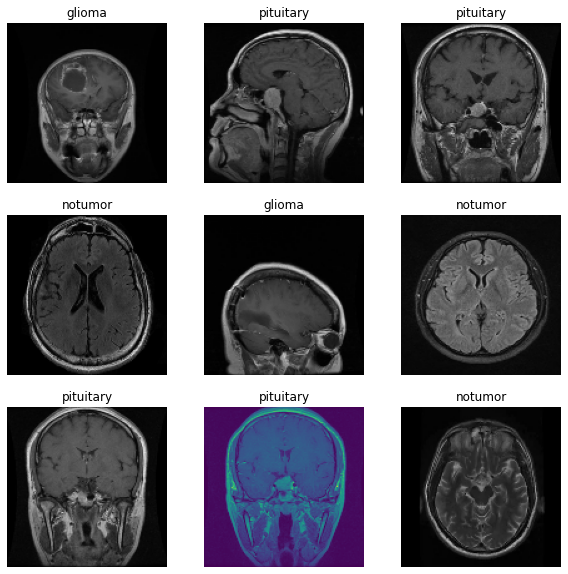

In [37]:
batch_size = 64
image_height = 128
image_width = 128
data_dir = '/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/Training'
train_ds, val_ds = load_data(data_dir, image_height, image_width, batch_size)

for image_batch, labels_batch in train_ds:
    print("Image Batch Shape:", image_batch.shape)
    print("Label Batch Shape:",labels_batch.shape)
    break

print("Class Names:", train_ds.class_names)
visualize_data(train_ds)

In [38]:
#### Model Hyperparameters ####
learning_rate = 0.001

## learning rate decay parameters ##
decay_steps = 110.0
decay_rate = 0.1
learning_rate_scheduler = keras.optimizers.schedules.InverseTimeDecay(
    learning_rate, decay_steps, decay_rate, staircase=False, name=None)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
epochs = 30
###############################

model = TF_BrainClassifier(train_ds.class_names, image_height, image_width)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 128)      

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
  )

Epoch 1/30


2023-05-24 11:58:51.509278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 634.7211 - accuracy: 0.5684

2023-05-24 11:59:50.682441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 64s 545ms/step - loss: 634.7211 - accuracy: 0.5684 - val_loss: 57.6465 - val_accuracy: 0.5083
Epoch 2/30
110/110 [==============================] - 60s 542ms/step - loss: 53.2873 - accuracy: 0.6015 - val_loss: 50.4074 - val_accuracy: 0.3459
Epoch 3/30
110/110 [==============================] - 60s 541ms/step - loss: 47.3914 - accuracy: 0.6298 - val_loss: 45.6788 - val_accuracy: 0.3368
Epoch 4/30
110/110 [==============================] - 61s 552ms/step - loss: 43.1391 - accuracy: 0.6701 - val_loss: 41.0777 - val_accuracy: 0.7236
Epoch 5/30
110/110 [==============================] - 60s 550ms/step - loss: 39.6746 - accuracy: 0.7055 - val_loss: 38.0889 - val_accuracy: 0.6934
Epoch 6/30
110/110 [==============================] - 61s 553ms/step - loss: 36.7173 - accuracy: 0.7339 - val_loss: 35.5095 - val_accuracy: 0.7567
Epoch 7/30
110/110 [==============================] - 60s 544ms/step - loss: 34.2005 - accuracy: 0.7756 - val_loss: 33.0270 - va

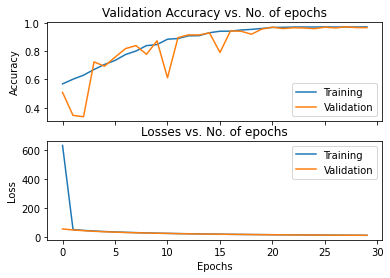

In [40]:
def plot_results(history):
    epoch_lst = list(range(epochs))
    accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(epoch_lst, accuracies)
    ax1.plot(epoch_lst, val_accuracies)
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Validation Accuracy vs. No. of epochs')
    ax1.set(ylabel='Accuracy')
    ax2.plot(epoch_lst, loss)
    ax2.plot(epoch_lst, val_loss)
    ax2.set_title('Losses vs. No. of epochs')
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()

plot_results(history)

In [41]:
model.save('/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/tf_model.pth')

INFO:tensorflow:Assets written to: /Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/tf_model.pth/assets
